In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from clingo import Control


In [2]:
pip install clingo


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load data from CSV

def read_json(file_path, encoding='utf-8'):
    with open(file_path, 'r', encoding=encoding) as file:
        data = json.load(file)
    return data


# Read data from JSON files
locations = read_json('../Data/locations.json')
location_types = read_json('../Data/LocationType.json')["RECORDS"]
routes = read_json('../Data/distances.json')
trucks = read_json('../Data/trucks.json')
containers = read_json('../Data/containers.json')
orders = read_json('../Data/orders.json')



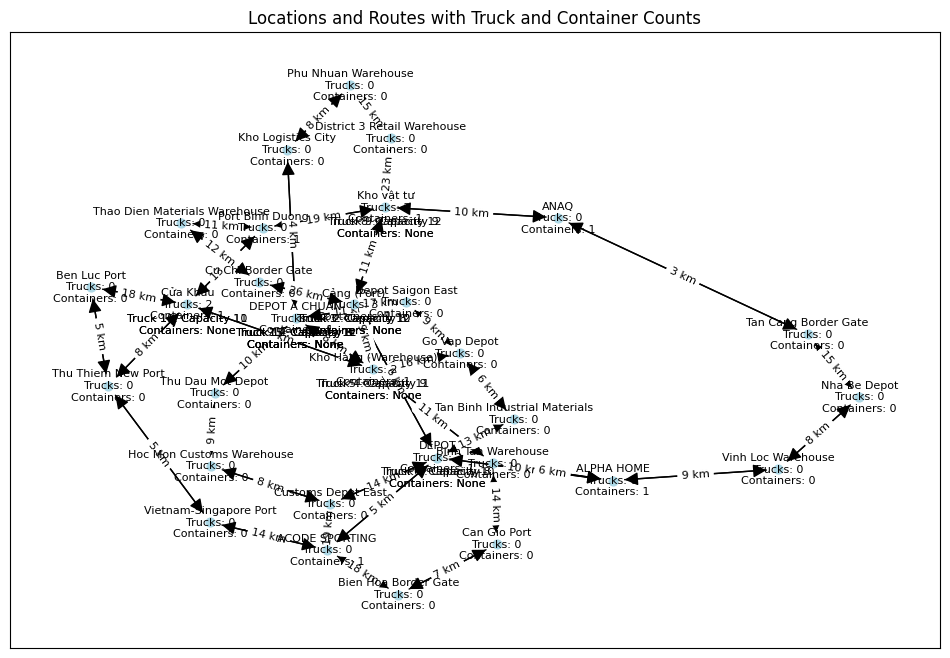

In [4]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes with location type as a label
for loc in locations:
    loc_type = loc["Type"] if loc["Type"] else "Unknown"
    G.add_node(loc["LocationID"], label=f'{loc["Name"]} ({loc_type})')

# Add edges with distances as weights
for route in routes:
    G.add_edge(route["From"], route["To"], weight=route["DistanceKm"])

# Count trucks and containers at each location
location_trucks = defaultdict(int)
location_containers = defaultdict(int)
truck_conts = defaultdict(list)

for truck in trucks:
    location_trucks[truck["current_location"]] += 1
    if truck["conts"] is not None:
        for cont in truck["conts"]:
            truck_conts[truck["CarID"]].append(f'{cont["ContNumber"]} ({cont["Status"]})')

for container in containers:
    location_containers[container["ArrLocationDepotCode"][0]] += 1  # Assuming the first location in ArrLocationDepotCode is the current location

# Set up node labels to include truck and container counts
node_labels = {loc["LocationID"]: f'{loc["Name"]}\nTrucks: {location_trucks[loc["LocationID"]]}\nContainers: {location_containers[loc["LocationID"]]}' for loc in locations}

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(12, 8))

# Draw nodes with labels
nx.draw_networkx_nodes(G, pos, node_size=40, node_color='lightblue')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

# Draw edges with weights
edge_labels = {(u, v): f'{d["weight"]} km' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Add truck information to the plot
for truck in trucks:
    if truck["conts"] is not None:
        truck_info = f'Truck {truck["CarID"]}: Capacity {truck["capacity"]}\nContainers: {"; ".join(truck_conts[truck["CarID"]])}'
    else:
        truck_info = f'Truck {truck["CarID"]}: Capacity {truck["capacity"]}\nContainers: None'
    plt.text(pos[truck["current_location"]][0], pos[truck["current_location"]][1] - 0.1, truck_info, fontsize=8, ha='center')

plt.title("Locations and Routes with Truck and Container Counts")
plt.show()

# RULEBOOK

In [5]:
# Print the read data for verification
print("Locations:", locations)
print("Location Types:", location_types)
print("Routes:", routes)
print("Trucks:", trucks)
print("Orders:", orders)
print("Containers:", containers)

Locations: [{'LocationID': 'LOC001', 'Name': 'Cảng (Port)', 'Type': 'Port', 'Address': 'District 7, Ho Chi Minh City', 'Coordinates': {'x': 10.7365, 'y': 106.722}}, {'LocationID': 'LOC002', 'Name': 'Kho Hàng (Warehouse)', 'Type': 'Warehouse', 'Address': 'District 2, Ho Chi Minh City', 'Coordinates': {'x': 10.7877, 'y': 106.749}}, {'LocationID': 'LOC003', 'Name': 'DEPOT', 'Type': 'Depot', 'Address': 'District 9, Ho Chi Minh City', 'Coordinates': {'x': 10.852, 'y': 106.775}}, {'LocationID': 'LOC004', 'Name': 'Kho vật tư', 'Type': 'Kho_vat_tu', 'Address': 'Binh Thanh District, Ho Chi Minh City', 'Coordinates': {'x': 10.8015, 'y': 106.707}}, {'LocationID': 'LOC005', 'Name': 'Cửa Khẩu', 'Type': 'Cua_khau', 'Address': 'District 5, Ho Chi Minh City', 'Coordinates': {'x': 10.7563, 'y': 106.667}}, {'LocationID': 'LOC006', 'Name': 'DEPOT A CHUAN', 'Type': 'Depot', 'Address': 'Bình Chuẩn 60, Bình Chuẩn, Tp. Thủ Dầu Một, Bình Dương', 'Coordinates': {'x': 10.9835, 'y': 106.683}}, {'LocationID': 'LO

In [8]:
def generate_asp_code(locations, routes, trucks, orders, containers):
    asp_code = ""
    
    # Define locations and types
    asp_code += "\n".join([f'location({loc["LocationID"]}). location_type({loc["LocationID"]}, "{loc["Type"]}").' for loc in locations]) + "\n"
    
    # Define routes and distances between locations
    asp_code += "\n".join([f'route({route["From"]}, {route["To"]}, {route["DistanceKm"]}).' for route in routes]) + "\n"
    
    # Define trucks
    asp_code += "\n".join([f'truck({truck["CarID"]}). capacity({truck["CarID"]}, {truck["capacity"]}). current_location({truck["CarID"]}, {truck["current_location"]}).' for truck in trucks]) + "\n"
    
    # Define containers
    asp_code += "\n".join([f'container({container["ContNumber"]}). current_truck({container["ContNumber"]}, {container["OrderId"] if container["OrderId"] else "null"}). is_cargo({container["ContNumber"]}, {str(container["IsCargo"]).lower()}).' for container in containers]) + "\n"
    
    # Define tasks from orders
    for order in orders:
        if order["OrderType"] == "Booking":
            asp_code += f'order({order["Code"]}, booking, {order["ArrLocationReciptCode"][0]}, {order["ArrLocationReciptCode"][1]}, {order["Book_ETA"]}, {order["Book_ATA"]}).\n'
        elif order["OrderType"] == "Bill":
            asp_code += f'order({order["Code"]}, bill, {order["ArrLocationReciptCode"][0]}, {order["ArrLocationReciptCode"][1]}, {order["Bill_ETD"]}, {order["Bill_LastFreeDayDET"]}).\n'
    
    # Example of assigning tasks to trucks
    asp_code += "{ assigned(T, K) : truck(K) } = 1 :- task(T).\n"
    
    # Define the route taken by each truck
    asp_code += "{ route(K, L1, L2) : location(L1), location(L2) } :- truck(K).\n"
    
    # Ensure routes are valid
    asp_code += ":- route(K, L1, L2), not location(L1), not location(L2).\n"
    
    # Define constraints to prioritize tasks with tighter deadlines and minimize travel distances
    asp_code += ":- pickup(T1, L1), dropoff(T2, L2), order(T1, booking), order(T2, bill), T1 < T2, not assigned(T1, K), assigned(T2, K).\n"
    asp_code += ":- route(K, L1, L2, D1), route(K, L2, L3, D2), D1 > D2, assigned(T1, K), assigned(T2, K), T1 != T2.\n"
    asp_code += ":- assigned(T, K), capacity(K, C), load(T, L), L > C.\n"
    
    # Show assigned tasks and routes
    asp_code += "#show assigned/2.\n"
    asp_code += "#show route/3.\n"
    
    return asp_code

# Generate ASP code
asp_code = generate_asp_code(locations, routes, trucks, orders, containers)
print(asp_code)

location(LOC001). location_type(LOC001, "Port").
location(LOC002). location_type(LOC002, "Warehouse").
location(LOC003). location_type(LOC003, "Depot").
location(LOC004). location_type(LOC004, "Kho_vat_tu").
location(LOC005). location_type(LOC005, "Cua_khau").
location(LOC006). location_type(LOC006, "Depot").
location(LOC007). location_type(LOC007, "None").
location(LOC008). location_type(LOC008, "None").
location(LOC009). location_type(LOC009, "None").
location(LOC010). location_type(LOC010, "Port").
location(LOC011). location_type(LOC011, "Depot").
location(LOC012). location_type(LOC012, "Warehouse").
location(LOC013). location_type(LOC013, "Port").
location(LOC014). location_type(LOC014, "Depot").
location(LOC015). location_type(LOC015, "Warehouse").
location(LOC016). location_type(LOC016, "Cua_khau").
location(LOC017). location_type(LOC017, "Kho_vat_tu").
location(LOC018). location_type(LOC018, "Depot").
location(LOC019). location_type(LOC019, "Warehouse").
location(LOC020). locati

In [9]:
# Solve the VRP using Clingo
ctl = Control()
ctl.add("base", [], asp_code)
ctl.ground([("base", [])])

def on_model(m):
    print("Model found:")
    for atom in m.symbols(shown=True):
        print(atom)

result = ctl.solve(on_model=on_model)

if result.satisfiable:
    print("Solution found!")
else:
    print("No solution found.")

RuntimeError: parsing failed